In [1]:
import time
import os
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output

import pickle
def save_obj(obj:object,name:str):
    ext = '.pickle'
    with open(name + ext, 'wb') as handle:
        pickle.dump(obj, handle, protocol=pickle.HIGHEST_PROTOCOL)

def load_obj(name:str)->object:
    ext = '.pickle'
    with open(name + ext, 'rb') as handle:
        return pickle.load(handle)

In [2]:
train_path = "data/plagiarism/quora-question-pairs/train.csv"
df = pd.read_csv(train_path)

In [3]:
q1_embs = load_obj("data/plagiarism/quora-question-pairs/resluts/q1_embs")
q2_embs = load_obj("data/plagiarism/quora-question-pairs/resluts/q2_embs")
q2_embs[0].shape


(50, 384)

In [4]:
q1 = []
q2 = []
for i in range(len(q1_embs)):
    q1.extend(q1_embs[i])
    q2.extend(q2_embs[i])
q1 = np.array(list(map( lambda x: x.reshape(1,-1) ,q1)))
q2 = np.array(list(map( lambda x: x.reshape(1,-1) ,q2)))

# cosine

In [5]:
from sentence_transformers.util import cos_sim
q1_ = np.array(q1)
q2_ = np.array(q2)
cos_sim_matrix = np.array([cos_sim(q1_[i], q2_[i]).__array__() for i in range(len(q1_))])

In [6]:
cos_sim_matrix.shape

(404290, 1, 1)

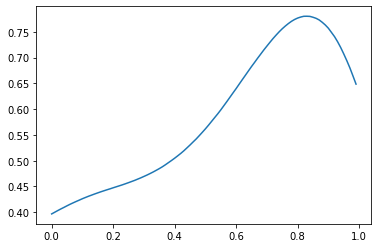

In [7]:
# tune the threshold
thresholds = np.arange(0.0, 1.0, 0.01)
accuracies = []
for threshold in thresholds:
    accuracies.append(np.mean(np.array(df['is_duplicate'].values.tolist()) == (cos_sim_matrix.reshape(-1,) > threshold)))
plt.plot(thresholds, accuracies)

In [8]:
accuracies.index(max(accuracies)), max(accuracies), thresholds[accuracies.index(max(accuracies))]

(83, 0.7802765341710158, 0.8300000000000001)

# neural network

## normal keras layer but subtract and abolute before

In [9]:
import tensorflow as tf
import tensorflow.keras.layers as layers
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split

def build_siamese_model(inputShape,units = 384):
	# specify the inputs for the feature extractor network
	inputs = tf.keras.layers.Input(inputShape)
	x = tf.keras.layers.Dense(units=units, activation='relu')(inputs)
	x = tf.keras.layers.Dropout(0.2)(x)
	outputs = tf.keras.layers.Dense(units=1, activation='sigmoid')(x)
	# build the model
	model = tf.keras.models.Model(inputs, outputs)
	# return the model to the calling function
	model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy']) 
	return model

def plot_history(history):
    # plot the training loss and accuracy vertically
    plt.style.use('ggplot')
    fig, ax = plt.subplots(1,2)
    fig.set_figheight(10)
    fig.set_figwidth(20)
    ax[0].plot(history.history['loss'], label='train')
    ax[0].plot(history.history['val_loss'], label='test')
    ax[0].legend()
    ax[0].set_title('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[1].plot(history.history['accuracy'], label='train')
    ax[1].plot(history.history['val_accuracy'], label='test')
    ax[1].legend()
    ax[1].set_title('Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    plt.show()


In [10]:
siamese = build_siamese_model(inputShape=(1,384),units=384)
siamese.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 384)]          0         
                                                                 
 dense (Dense)               (None, 1, 384)            147840    
                                                                 
 dropout (Dropout)           (None, 1, 384)            0         
                                                                 
 dense_1 (Dense)             (None, 1, 1)              385       
                                                                 
Total params: 148,225
Trainable params: 148,225
Non-trainable params: 0
_________________________________________________________________


In [11]:
# # train the model
differences = tf.abs(tf.subtract(q1,q2))

X = differences.__array__()
Y = df['is_duplicate'].values.reshape(-1,1)

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

history = siamese.fit(x_train, y_train, epochs=15, batch_size=64, validation_data=(x_test, y_test))

Epoch 1/15
5686/5686 [==============================] - 9s 2ms/step - loss: 0.4296 - accuracy: 0.7844 - val_loss: 0.4152 - val_accuracy: 0.7958
Epoch 2/15
5686/5686 [==============================] - 9s 2ms/step - loss: 0.4125 - accuracy: 0.7965 - val_loss: 0.4060 - val_accuracy: 0.8026
Epoch 3/15
5686/5686 [==============================] - 8s 1ms/step - loss: 0.4061 - accuracy: 0.8012 - val_loss: 0.4017 - val_accuracy: 0.8050
Epoch 4/15
5686/5686 [==============================] - 10s 2ms/step - loss: 0.4004 - accuracy: 0.8057 - val_loss: 0.3981 - val_accuracy: 0.8093
Epoch 5/15
5686/5686 [==============================] - 9s 1ms/step - loss: 0.3942 - accuracy: 0.8099 - val_loss: 0.3967 - val_accuracy: 0.8085
Epoch 6/15
5686/5686 [==============================] - 9s 2ms/step - loss: 0.3867 - accuracy: 0.8142 - val_loss: 0.3927 - val_accuracy: 0.8117
Epoch 7/15
5686/5686 [==============================] - 8s 1ms/step - loss: 0.3796 - accuracy: 0.8194 - val_loss: 0.3927 - val_accuracy

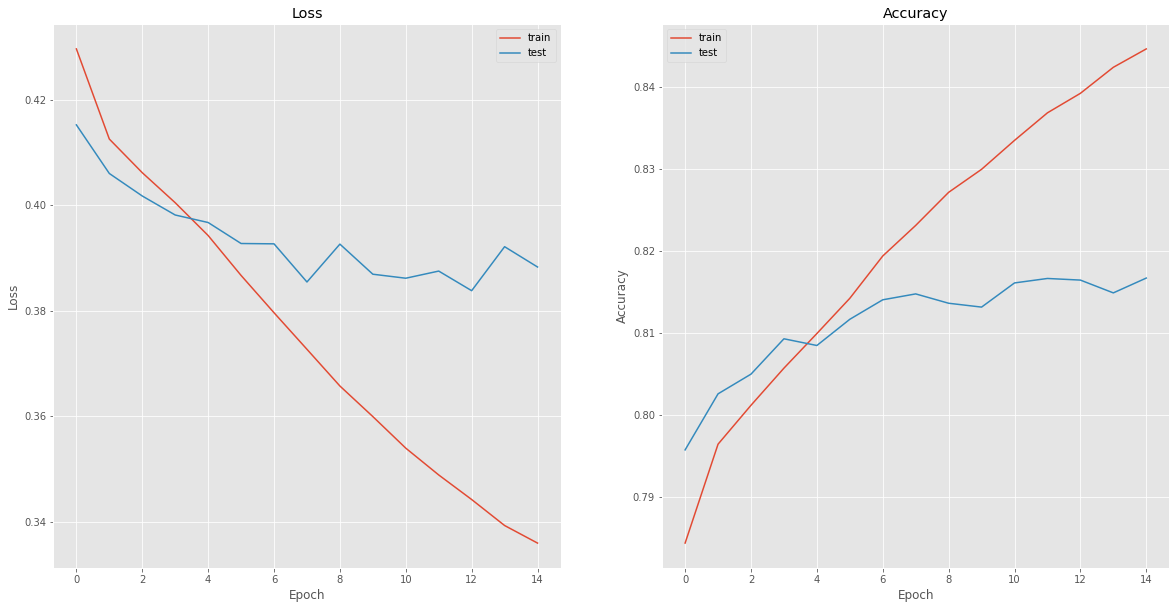

In [12]:
plot_history(history)

In [13]:
siamese_1 = build_siamese_model(inputShape=(1,384),units=384//2)
siamese_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1, 384)]          0         
                                                                 
 dense_2 (Dense)             (None, 1, 192)            73920     
                                                                 
 dropout_1 (Dropout)         (None, 1, 192)            0         
                                                                 
 dense_3 (Dense)             (None, 1, 1)              193       
                                                                 
Total params: 74,113
Trainable params: 74,113
Non-trainable params: 0
_________________________________________________________________


In [14]:
history_1 = siamese_1.fit(x_train, y_train, epochs=15, batch_size=64, validation_data=(x_test, y_test))

Epoch 1/15
5686/5686 [==============================] - 9s 2ms/step - loss: 0.4310 - accuracy: 0.7836 - val_loss: 0.4174 - val_accuracy: 0.7960
Epoch 2/15
5686/5686 [==============================] - 8s 1ms/step - loss: 0.4127 - accuracy: 0.7962 - val_loss: 0.4066 - val_accuracy: 0.8004
Epoch 3/15
5686/5686 [==============================] - 8s 1ms/step - loss: 0.4066 - accuracy: 0.8017 - val_loss: 0.4029 - val_accuracy: 0.8043
Epoch 4/15
5686/5686 [==============================] - 8s 1ms/step - loss: 0.4022 - accuracy: 0.8047 - val_loss: 0.4023 - val_accuracy: 0.8066
Epoch 5/15
5686/5686 [==============================] - 8s 1ms/step - loss: 0.3970 - accuracy: 0.8078 - val_loss: 0.3977 - val_accuracy: 0.8075
Epoch 6/15
5686/5686 [==============================] - 8s 1ms/step - loss: 0.3916 - accuracy: 0.8122 - val_loss: 0.3931 - val_accuracy: 0.8119
Epoch 7/15
5686/5686 [==============================] - 8s 1ms/step - loss: 0.3855 - accuracy: 0.8151 - val_loss: 0.3911 - val_accuracy:

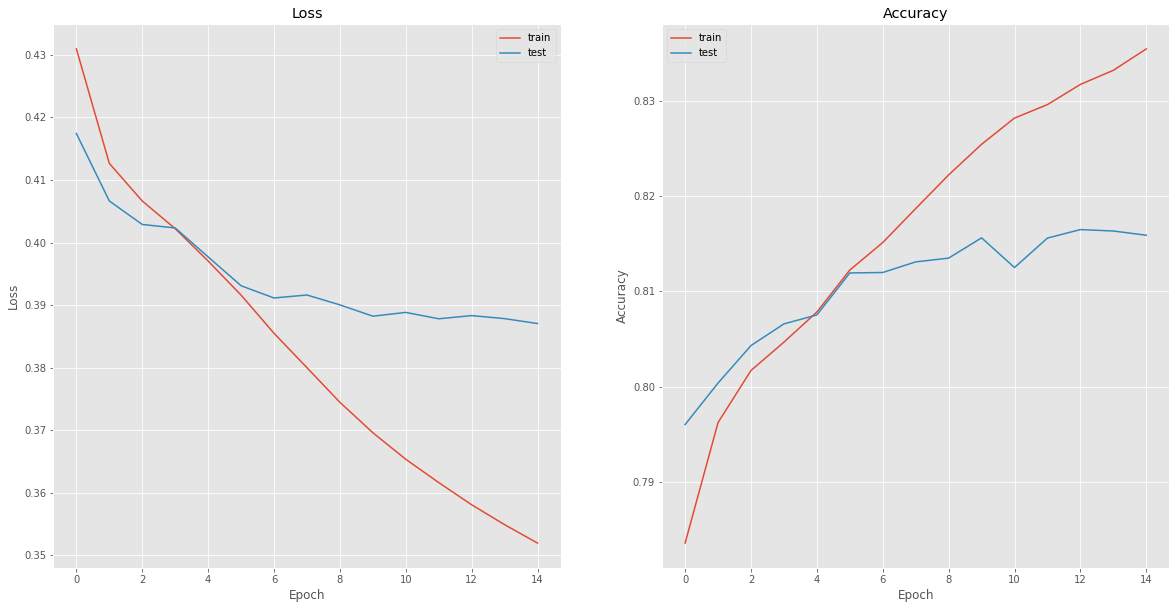

In [15]:
plot_history(history_1)

## layer of 192

In [16]:
siamese_1 = build_siamese_model(inputShape=(1,384),units=384//2)
siamese_1.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1, 384)]          0         
                                                                 
 dense_4 (Dense)             (None, 1, 192)            73920     
                                                                 
 dropout_2 (Dropout)         (None, 1, 192)            0         
                                                                 
 dense_5 (Dense)             (None, 1, 1)              193       
                                                                 
Total params: 74,113
Trainable params: 74,113
Non-trainable params: 0
_________________________________________________________________


In [17]:
history_1 = siamese_1.fit(x_train, y_train, epochs=20, batch_size=64, validation_data=(x_test, y_test))

Epoch 1/20
5686/5686 [==============================] - 9s 1ms/step - loss: 0.4301 - accuracy: 0.7845 - val_loss: 0.4175 - val_accuracy: 0.7977
Epoch 2/20
5686/5686 [==============================] - 8s 1ms/step - loss: 0.4132 - accuracy: 0.7963 - val_loss: 0.4097 - val_accuracy: 0.7995
Epoch 3/20
5686/5686 [==============================] - 8s 1ms/step - loss: 0.4080 - accuracy: 0.8005 - val_loss: 0.4039 - val_accuracy: 0.8049
Epoch 4/20
5686/5686 [==============================] - 8s 1ms/step - loss: 0.4020 - accuracy: 0.8046 - val_loss: 0.4039 - val_accuracy: 0.8038
Epoch 5/20
5686/5686 [==============================] - 8s 1ms/step - loss: 0.3966 - accuracy: 0.8085 - val_loss: 0.3979 - val_accuracy: 0.8084
Epoch 6/20
5686/5686 [==============================] - 8s 1ms/step - loss: 0.3903 - accuracy: 0.8126 - val_loss: 0.3923 - val_accuracy: 0.8129
Epoch 7/20
5686/5686 [==============================] - 8s 1ms/step - loss: 0.3841 - accuracy: 0.8167 - val_loss: 0.3965 - val_accuracy:

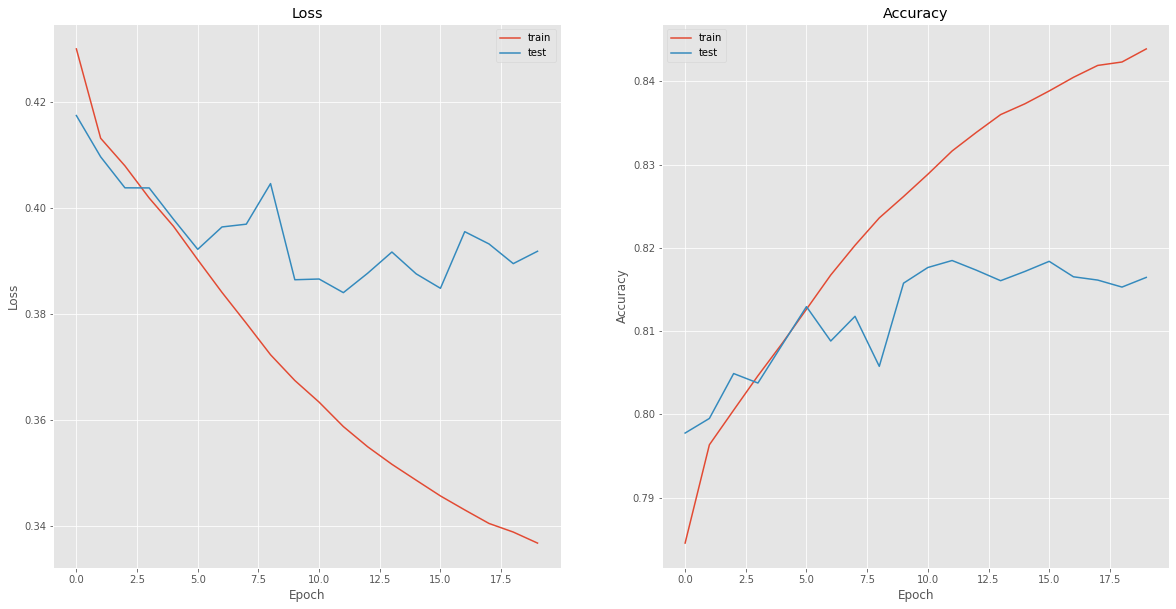

In [18]:
plot_history(history_1)

# just difference

In [19]:
def build_siamese(inputShape):
	# specify the inputs for the feature extractor network
	inputs = tf.keras.layers.Input(inputShape)
	outputs = tf.keras.layers.Dense(units=1, activation='sigmoid')(inputs)
	model = tf.keras.models.Model(inputs, outputs)
	# return the model to the calling function
	model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy']) 
	return model

In [20]:
siamese_2 = build_siamese(inputShape=(1,384))
siamese_2.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1, 384)]          0         
                                                                 
 dense_6 (Dense)             (None, 1, 1)              385       
                                                                 
Total params: 385
Trainable params: 385
Non-trainable params: 0
_________________________________________________________________


In [21]:
history_2 = siamese_1.fit(x_train, y_train, epochs=20, batch_size=64, validation_data=(x_test, y_test))

Epoch 1/20
5686/5686 [==============================] - 9s 1ms/step - loss: 0.3348 - accuracy: 0.8457 - val_loss: 0.3909 - val_accuracy: 0.8142
Epoch 2/20
5686/5686 [==============================] - 9s 2ms/step - loss: 0.3325 - accuracy: 0.8462 - val_loss: 0.3955 - val_accuracy: 0.8164
Epoch 3/20
5686/5686 [==============================] - 8s 1ms/step - loss: 0.3304 - accuracy: 0.8473 - val_loss: 0.3971 - val_accuracy: 0.8147
Epoch 4/20
5686/5686 [==============================] - 8s 1ms/step - loss: 0.3294 - accuracy: 0.8478 - val_loss: 0.3987 - val_accuracy: 0.8163
Epoch 5/20
5686/5686 [==============================] - 9s 2ms/step - loss: 0.3275 - accuracy: 0.8489 - val_loss: 0.3951 - val_accuracy: 0.8162
Epoch 6/20
5686/5686 [==============================] - 8s 1ms/step - loss: 0.3261 - accuracy: 0.8495 - val_loss: 0.3941 - val_accuracy: 0.8132
Epoch 7/20
5686/5686 [==============================] - 8s 1ms/step - loss: 0.3248 - accuracy: 0.8506 - val_loss: 0.3989 - val_accuracy:

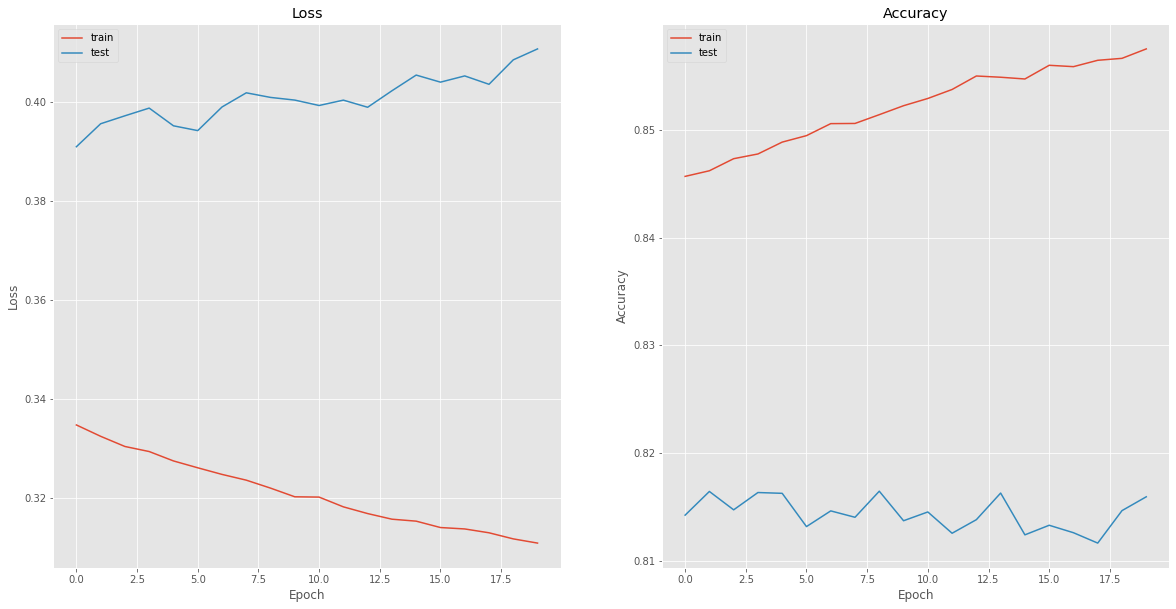

In [23]:
plot_history(history_2)

In [24]:
def build_siamese(inputShape,units=64):
	# specify the inputs for the feature extractor network
	inputs = tf.keras.layers.Input(inputShape)
	x = tf.keras.layers.Dense(units=units, activation='relu')(inputs)
	x = tf.keras.layers.Dropout(0.2)(x)
	outputs = tf.keras.layers.Dense(units=1, activation='sigmoid')(x)
	# build the model
	model = tf.keras.models.Model(inputs, outputs)
	# return the model to the calling function
	model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy']) 
	return model

In [25]:
siamese_3 = build_siamese(inputShape=(1,384))

In [26]:
history_3 = siamese_3.fit(x_train, y_train, epochs=20, batch_size=64, validation_data=(x_test, y_test))

Epoch 1/20
5686/5686 [==============================] - 7s 1ms/step - loss: 0.4323 - accuracy: 0.7833 - val_loss: 0.4199 - val_accuracy: 0.7935
Epoch 2/20
5686/5686 [==============================] - 6s 1ms/step - loss: 0.4152 - accuracy: 0.7945 - val_loss: 0.4079 - val_accuracy: 0.8008
Epoch 3/20
5686/5686 [==============================] - 6s 1ms/step - loss: 0.4103 - accuracy: 0.7989 - val_loss: 0.4069 - val_accuracy: 0.8006
Epoch 4/20
5686/5686 [==============================] - 6s 1ms/step - loss: 0.4067 - accuracy: 0.8016 - val_loss: 0.4048 - val_accuracy: 0.8031
Epoch 5/20
5686/5686 [==============================] - 6s 1ms/step - loss: 0.4028 - accuracy: 0.8052 - val_loss: 0.4024 - val_accuracy: 0.8044
Epoch 6/20
5686/5686 [==============================] - 6s 1ms/step - loss: 0.3992 - accuracy: 0.8073 - val_loss: 0.4022 - val_accuracy: 0.8053
Epoch 7/20
5686/5686 [==============================] - 6s 1ms/step - loss: 0.3950 - accuracy: 0.8101 - val_loss: 0.4007 - val_accuracy:

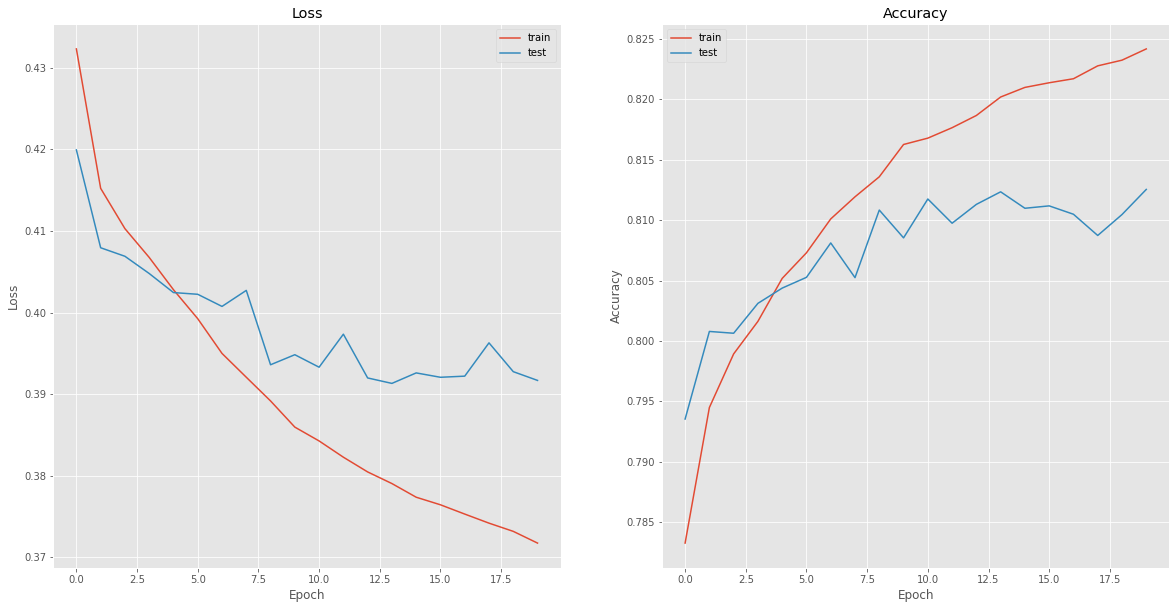

In [27]:
plot_history(history_3)

In [28]:
def build_siamese(inputShape,units1=128,units2=64):
	# specify the inputs for the feature extractor network
	inputs = tf.keras.layers.Input(inputShape)
	x = tf.keras.layers.Dense(units=units1, activation='relu')(inputs)
	x = tf.keras.layers.Dropout(0.2)(x)
	x = tf.keras.layers.Dense(units=units2, activation='relu')(x)
	outputs = tf.keras.layers.Dense(units=1, activation='sigmoid')(x)
	# build the model
	model = tf.keras.models.Model(inputs, outputs)
	# return the model to the calling function
	model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy']) 
	return model
siamese_4 = build_siamese(inputShape=(1,384))
siamese_4.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 1, 384)]          0         
                                                                 
 dense_9 (Dense)             (None, 1, 128)            49280     
                                                                 
 dropout_4 (Dropout)         (None, 1, 128)            0         
                                                                 
 dense_10 (Dense)            (None, 1, 64)             8256      
                                                                 
 dense_11 (Dense)            (None, 1, 1)              65        
                                                                 
Total params: 57,601
Trainable params: 57,601
Non-trainable params: 0
_________________________________________________________________


In [29]:
history_4 = siamese_4.fit(x_train, y_train, epochs=20, batch_size=64, validation_data=(x_test, y_test))

Epoch 1/20
5686/5686 [==============================] - 9s 1ms/step - loss: 0.4294 - accuracy: 0.7852 - val_loss: 0.4106 - val_accuracy: 0.7997
Epoch 2/20
5686/5686 [==============================] - 8s 1ms/step - loss: 0.4118 - accuracy: 0.7987 - val_loss: 0.4132 - val_accuracy: 0.7995
Epoch 3/20
5686/5686 [==============================] - 8s 1ms/step - loss: 0.4063 - accuracy: 0.8021 - val_loss: 0.4037 - val_accuracy: 0.8059
Epoch 4/20
5686/5686 [==============================] - 8s 1ms/step - loss: 0.4025 - accuracy: 0.8050 - val_loss: 0.4066 - val_accuracy: 0.8040
Epoch 5/20
5686/5686 [==============================] - 8s 1ms/step - loss: 0.3988 - accuracy: 0.8074 - val_loss: 0.4026 - val_accuracy: 0.8083
Epoch 6/20
5686/5686 [==============================] - 8s 1ms/step - loss: 0.3951 - accuracy: 0.8097 - val_loss: 0.4012 - val_accuracy: 0.8097
Epoch 7/20
5686/5686 [==============================] - 8s 1ms/step - loss: 0.3922 - accuracy: 0.8113 - val_loss: 0.3961 - val_accuracy:

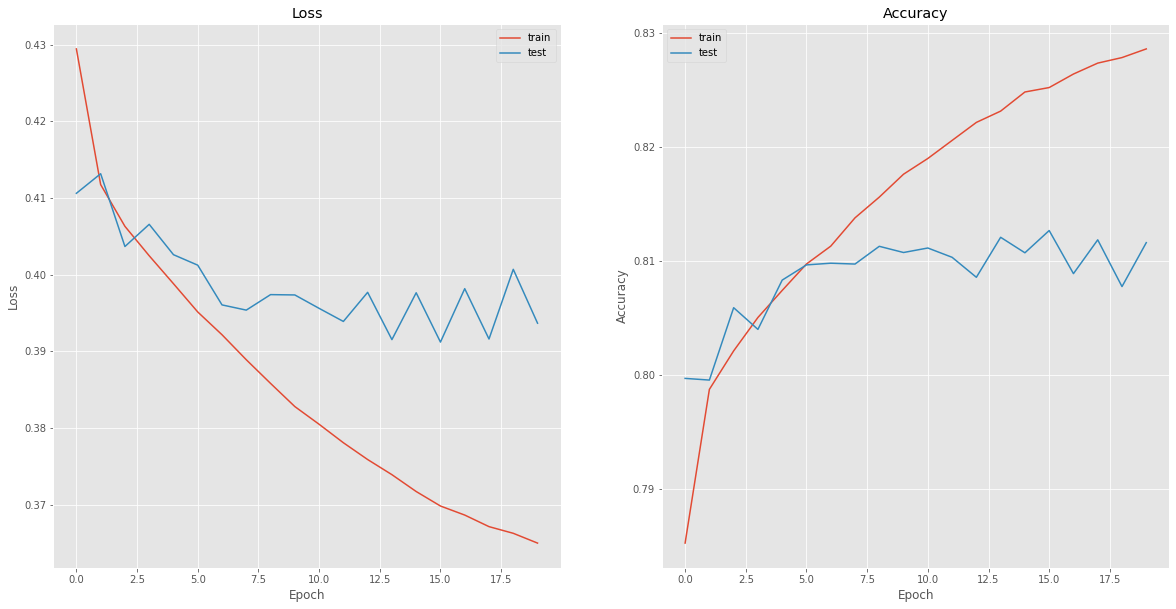

In [30]:
plot_history(history_4)